# Импортируем библиотеки

In [90]:
import numpy as np #numpy для работа с матрицами
import pandas as pd #для хранения истории обучения и ее визуализации
import matplotlib.pyplot as plt #matplotlib для визуализации
import seaborn as sns #seaborn для визуализации

from sklearn.metrics import classification_report #отчет по классификации
from sklearn.metrics import confusion_matrix #матрица ошибок
from sklearn.datasets import load_digits #загрузчик датасетов
from sklearn.model_selection import train_test_split #авторазбиение на train/test
from sklearn.metrics import accuracy_score, f1_score

from keras.models import Sequential #последовательная модель (прямого распространения)
from keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Activation, MaxPooling2D, Dropout #слои
from keras import optimizers #оптимизаторы
from keras.losses import CategoricalCrossentropy #категориальная кроссэнтропия
from keras.utils import to_categorical #преобразование в категориальные данные

# Загружаем датасет с рукописными цифрами

In [91]:
digits = load_digits()

Изучим форматы хранения

In [92]:
print('Количество изображений и их ширина и высота:', digits.images.shape) #1797 изображений размером 8x8
print('Количество объектов и признаков в данных:', digits.data.shape) #1797 изображений с 64 признаками (признак - яркость каждого пикселя)
print('Количество меток:', digits.target.shape) #1797 лейблов

Количество изображений и их ширина и высота: (1797, 8, 8)
Количество объектов и признаков в данных: (1797, 64)
Количество меток: (1797,)


Размерность изображения

In [93]:
image_shape = digits.images.shape[1:] + (1,)
image_shape

(8, 8, 1)

Получим данные

In [94]:
# преобразуем данные входа в массив numpy
images09 = np.asarray(digits.images, dtype='float32') 
data09 = np.asarray(digits.data, dtype='float32')
target09 = np.asarray(digits.target, dtype='int32')

X = images09
y = target09

# количество классов
classes_n = len(np.unique(target09))
classes_n

10

Выведем изображения для примера

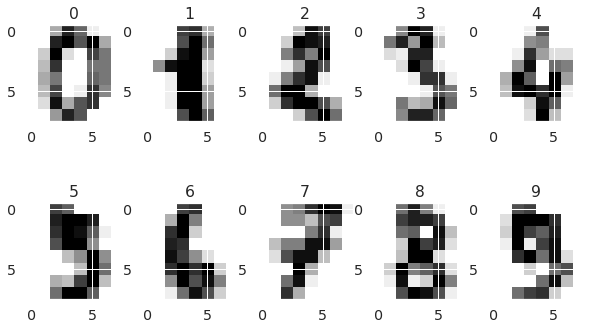

In [95]:
df = pd.DataFrame(y)

fig, ax = plt.subplots(2, 5, figsize=(10, 6))

for i in range(classes_n):
  ax[i // 5][i % 5].imshow(images09[df[0] == i][0], cmap=plt.cm.gray_r, interpolation='nearest')
  ax[i // 5][i % 5].set_title(i)

plt.show()

Рассмотрим распределение классов

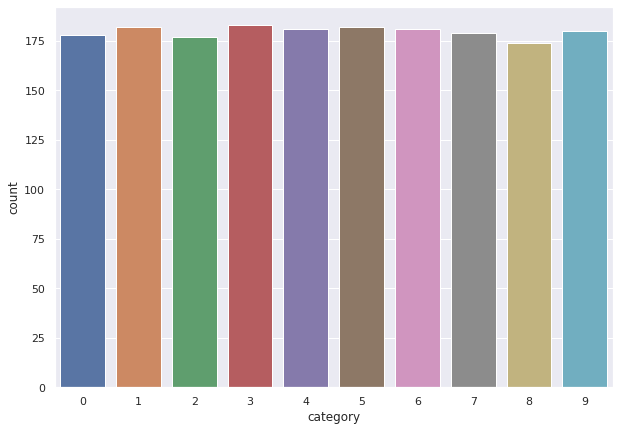

In [96]:
sns.set(rc={'figure.figsize':(10, 7)})
sns.countplot(x=target09)
plt.xlabel("category", size = 12)
plt.show()

Видно, что классы являются сбалансированными.

# Подготовим данные

Разобьем выборку на обучающую и тестовую

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20% на тест, неслучайная повторяемость по состоянию 42
print('Количество объектов и признаков в обучающих данных:', X_train.shape)
print('Количество меток в обучающих данных:', y_train.shape)
print('Количество объектов и признаков в тестовых данных:', X_test.shape)
print('Количество меток в тестовых данных:', y_test.shape)

Количество объектов и признаков в обучающих данных: (1437, 8, 8)
Количество меток в обучающих данных: (1437,)
Количество объектов и признаков в тестовых данных: (360, 8, 8)
Количество меток в тестовых данных: (360,)


Преобразуем с помощью one-hot encoding в категориальные данные выходные

In [98]:
Y_train = to_categorical(y_train)
Y_train[:5] #выведем 5 первых целевых признаков

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Смоделируем нейронную сеть



In [99]:
model = Sequential() #создаем последовательное соединение слоев с прямым распространением
model.add(Conv2D(64, kernel_size=3, strides=(2, 2), input_shape=image_shape, padding='same', activation='relu', name='input'))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(classes_n, 'softmax')) #создаем выходной слой с активацией softmax

Выведем краткую информацию о модели

In [100]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 4, 4, 64)          640       
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 64)          0         
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_11 (Dropout)        (None, 1024)             

Компилируем нейронную сеть с методом оптимизации Adam.

В качестве функции потерь выбираем категориальную кроссэнтропию.

В качестве основной метрики оцениваем accuracy (долю верных распознаваний).

In [101]:
model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Обучаем модель на train датасете

Используем 20% данных в качестве валидации.

Обучаем в течение 20 эпох и используем на одном этапе обучения 32 примера.

In [102]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
36/36 [==============================] - 3s 30ms/step - loss: 1.0162 - accuracy: 0.6832 - val_loss: 0.2987 - val_accuracy: 0.9028
Epoch 2/20
36/36 [==============================] - 1s 23ms/step - loss: 0.1984 - accuracy: 0.9391 - val_loss: 0.1558 - val_accuracy: 0.9479
Epoch 3/20
36/36 [==============================] - 1s 25ms/step - loss: 0.1045 - accuracy: 0.9704 - val_loss: 0.1550 - val_accuracy: 0.9410
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0816 - accuracy: 0.9774 - val_loss: 0.1722 - val_accuracy: 0.9583
Epoch 5/20
36/36 [==============================] - 1s 23ms/step - loss: 0.0609 - accuracy: 0.9774 - val_loss: 0.1285 - val_accuracy: 0.9583
Epoch 6/20
36/36 [==============================] - 1s 31ms/step - loss: 0.0282 - accuracy: 0.9922 - val_loss: 0.0957 - val_accuracy: 0.9722
Epoch 7/20
36/36 [==============================] - 1s 39ms/step - loss: 0.0198 - accuracy: 0.9930 - val_loss: 0.0926 - val_accuracy: 0.9722
Epoch 8/20
36

Сохраним историю обучения в датафрейме pandas

In [103]:
history_df = pd.DataFrame(history.history) #создаем датафрейм и записываем туда метрики из истории
history_df["epoch"] = history.epoch #создаем столбец с номерами эпох обучения (начинаем с 0)
history_df #выводим датафрейм

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.016247,0.683203,0.298730,0.902778,0
1,0.198444,0.939077,0.155826,0.947917,1
2,0.104550,0.970409,0.154995,0.940972,2
3,0.081585,0.977372,0.172213,0.958333,3
4,0.060930,0.977372,0.128491,0.958333,4
5,0.028206,0.992167,0.095729,0.972222,5
6,0.019826,0.993037,0.092631,0.972222,6
7,0.015276,0.993037,0.124294,0.961806,7
8,0.019033,0.992167,0.137728,0.961806,8
9,0.034302,0.991297,0.141119,0.961806,9


Строим кривые обучения

<AxesSubplot:xlabel='epoch'>

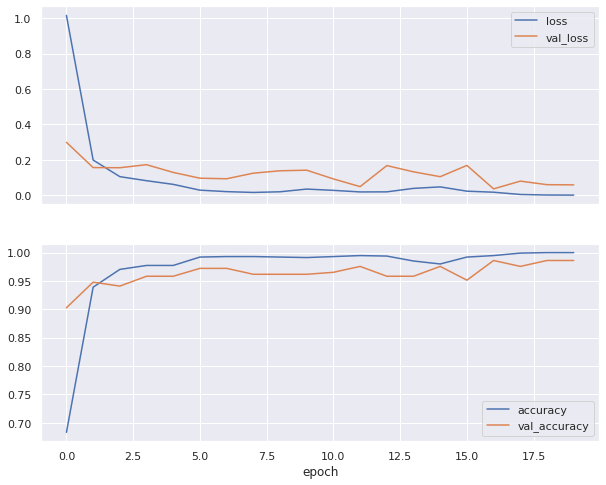

In [104]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8)) #создаем фигуру и оси для отрисовки 2 графиков
history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0, grid=True) #рисуем значения потерь для обучающих и валидационных данных
history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1, grid=True) #рисуем значения точности для обучающих и валидационных данных

# Сделаем прогноз для тестовых данных и оценим его

In [105]:
y_pred = np.argmax(model.predict(X_test), axis=1) #прогнозные значения

12/12 [==============================] - 0s 7ms/step


Отчет о классификации

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        46
           5       0.98      0.98      0.98        47
           6       0.97      0.97      0.97        35
           7       0.97      1.00      0.99        34
           8       1.00      1.00      1.00        30
           9       1.00      0.97      0.99        40

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



Функция вывода матрицы соответствий

In [107]:
def cm_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")
    return plt.show()

Выведем матрицу соответствий

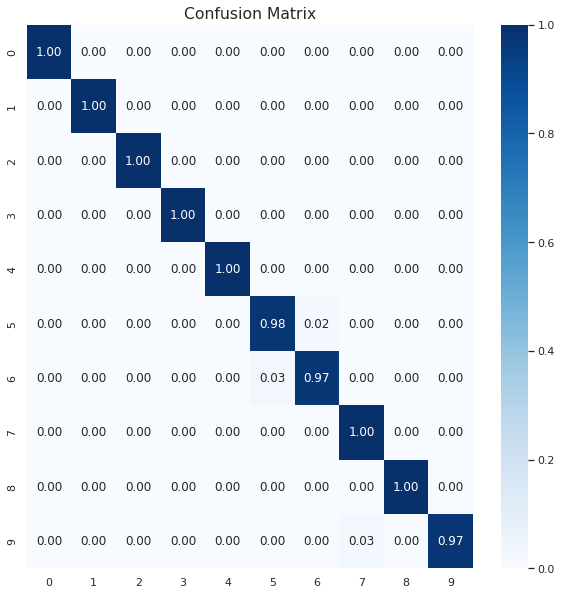

In [108]:
cm_plot(y_test, y_pred)

Выведем примеры изображений, которые были распознаны неверно.

In [109]:
y_dif = pd.DataFrame(abs(y_test - y_pred))

# количество неверно распознанных цифр
y_dif_len = len(y_dif[y_dif[0] > 0])
y_dif_len

3

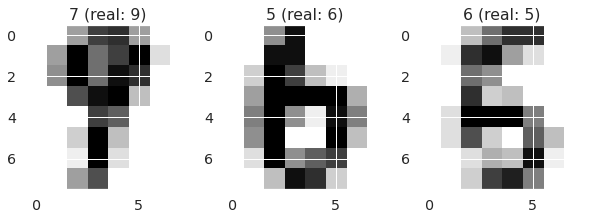

In [110]:
fig, ax = plt.subplots(1, y_dif_len, figsize=(10, 6))

j = 0
for i in range(y_dif_len):
  ax[j].imshow(X_test[y_dif[0] > 0][i], cmap=plt.cm.gray_r, interpolation='nearest')
  ax[j].set_title(str(y_pred[y_dif[0] > 0][i]) + ' (real: ' + str(y_test[y_dif[0] > 0][i]) + ')')
  j = j + 1

plt.show()